In [1]:
import re
import glob
import json
import joblib
import datetime
import holidays
import numpy as np
import pandas as pd
import geopandas as gpd
import lightgbm as lgb

from tqdm import tqdm

import matplotlib.pyplot as plt

### Обзор гео-данных

In [2]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [3]:
posts_df = pd.read_csv('../data/Датасет_04/02_координаты_станций.csv', sep=';', names=['post_name', 'latitude', 'longitude'])
posts = gpd.GeoDataFrame(
                posts_df, geometry=gpd.points_from_xy(posts_df.longitude, posts_df.latitude))

In [4]:
posts

,post_name,latitude,longitude,geometry
0,Академика,55.658163,37.471434,POINT (37.47143 55.65816)
1,Бутлерова,55.649412,37.535874,POINT (37.53587 55.64941)
2,Глебовская,55.811801,37.712490,POINT (37.71249 55.81180)
3,Коптевский,55.833222,37.525158,POINT (37.52516 55.83322)
4,Марьино,55.652695,37.751502,POINT (37.75150 55.65270)
5,Останкино,55.821154,37.612592,POINT (37.61259 55.82115)
6,Пролетарский,55.635129,37.658684,POINT (37.65868 55.63513)
7,Спиридоновка,55.759354,37.595584,POINT (37.59558 55.75935)
8,Туристская,55.856324,37.426628,POINT (37.42663 55.85632)
9,Шаболовка,55.715698,37.605238,POINT (37.60524 55.71570)


In [5]:
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

In [6]:
ao = gpd.read_file('../data/geo/ao.geojson')
mo = gpd.read_file('../data/geo/mo.geojson')

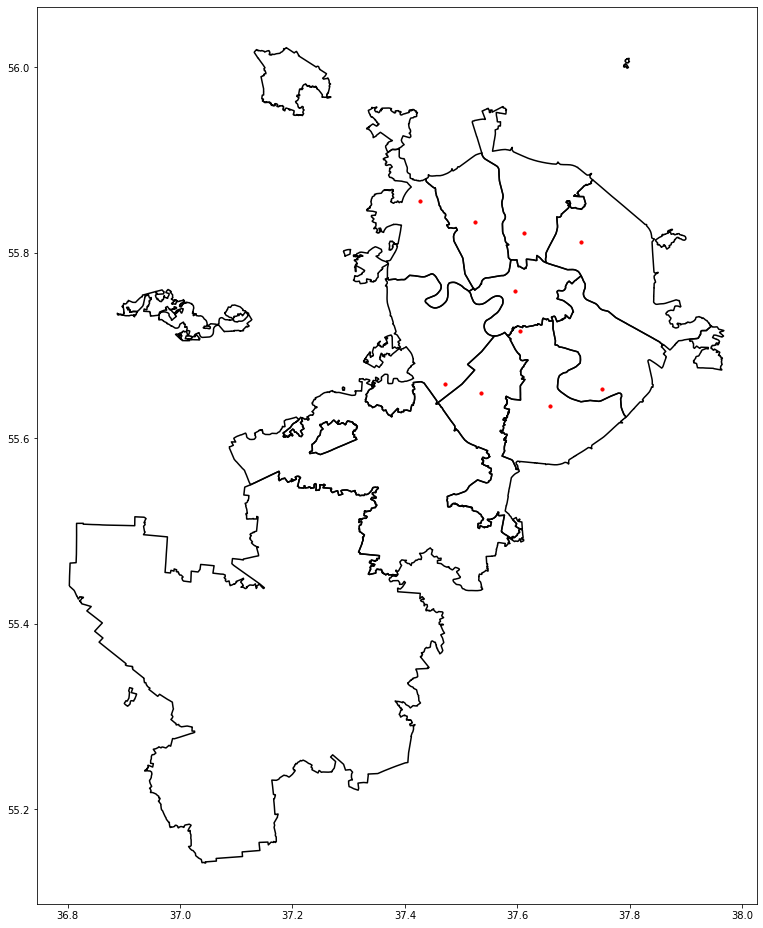

In [7]:
fig, ax = plt.subplots()

ao.boundary.plot(ax=ax, color='black', edgecolor='black')
#mo.boundary.plot(ax=ax, color='black', edgecolor='grey')
posts.plot(ax=ax, marker='o', color='red', markersize=10, aspect=1.65)
set_size(10,20)

plt.show()

### Создание датасета для обучения предиктора

In [8]:
datasets = {}
files = glob.glob('../data/Датасет_04/01_данные станций/[А-Я]*.xlsx')

for file in tqdm(files):
    name = re.findall(r'\w+', file)[4]
    data = pd.read_excel(file)
    data['Дата и время'] = pd.to_datetime(data['Дата и время'])
    #print(file, data.shape)
    data.dropna(subset=['Дата и время'], inplace=True)
    data.drop(data.loc[data['Дата и время'] >= '2021-01-01 00:00:00'].index, inplace=True)
    #print(file, data.shape)
    data = data.sort_values(by='Дата и время')
    datasets[name] = data

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:06<00:00, 12.67s/it]


In [9]:
def plot_report(data):
    fig, axs = plt.subplots(5)

    axs[0].plot(data['Дата и время'], data['CO'])

    axs[1].plot(data['Дата и время'], data['NO2'])
    axs[1].plot(data['Дата и время'], data['NO'])
    axs[1].plot(data['Дата и время'], data['PM10'])

    axs[2].plot(data['Дата и время'], data['Осадки'])
    axs[2].plot(data['Дата и время'], data['-T-'])
    axs[2].plot(data['Дата и время'], data['| V |'])

    axs[3].plot(data['Дата и время'], data['Давление'])

    axs[4].plot(data['Дата и время'], data['Влажность'])



    axs[0].legend(['CO'])
    axs[1].legend(['NO2', 'NO', 'PM10'])
    axs[2].legend(['Осадки', '-T-', '| V |'])
    axs[3].legend(['Давление'])
    axs[4].legend(['Влажность'])

    set_size(25,15)

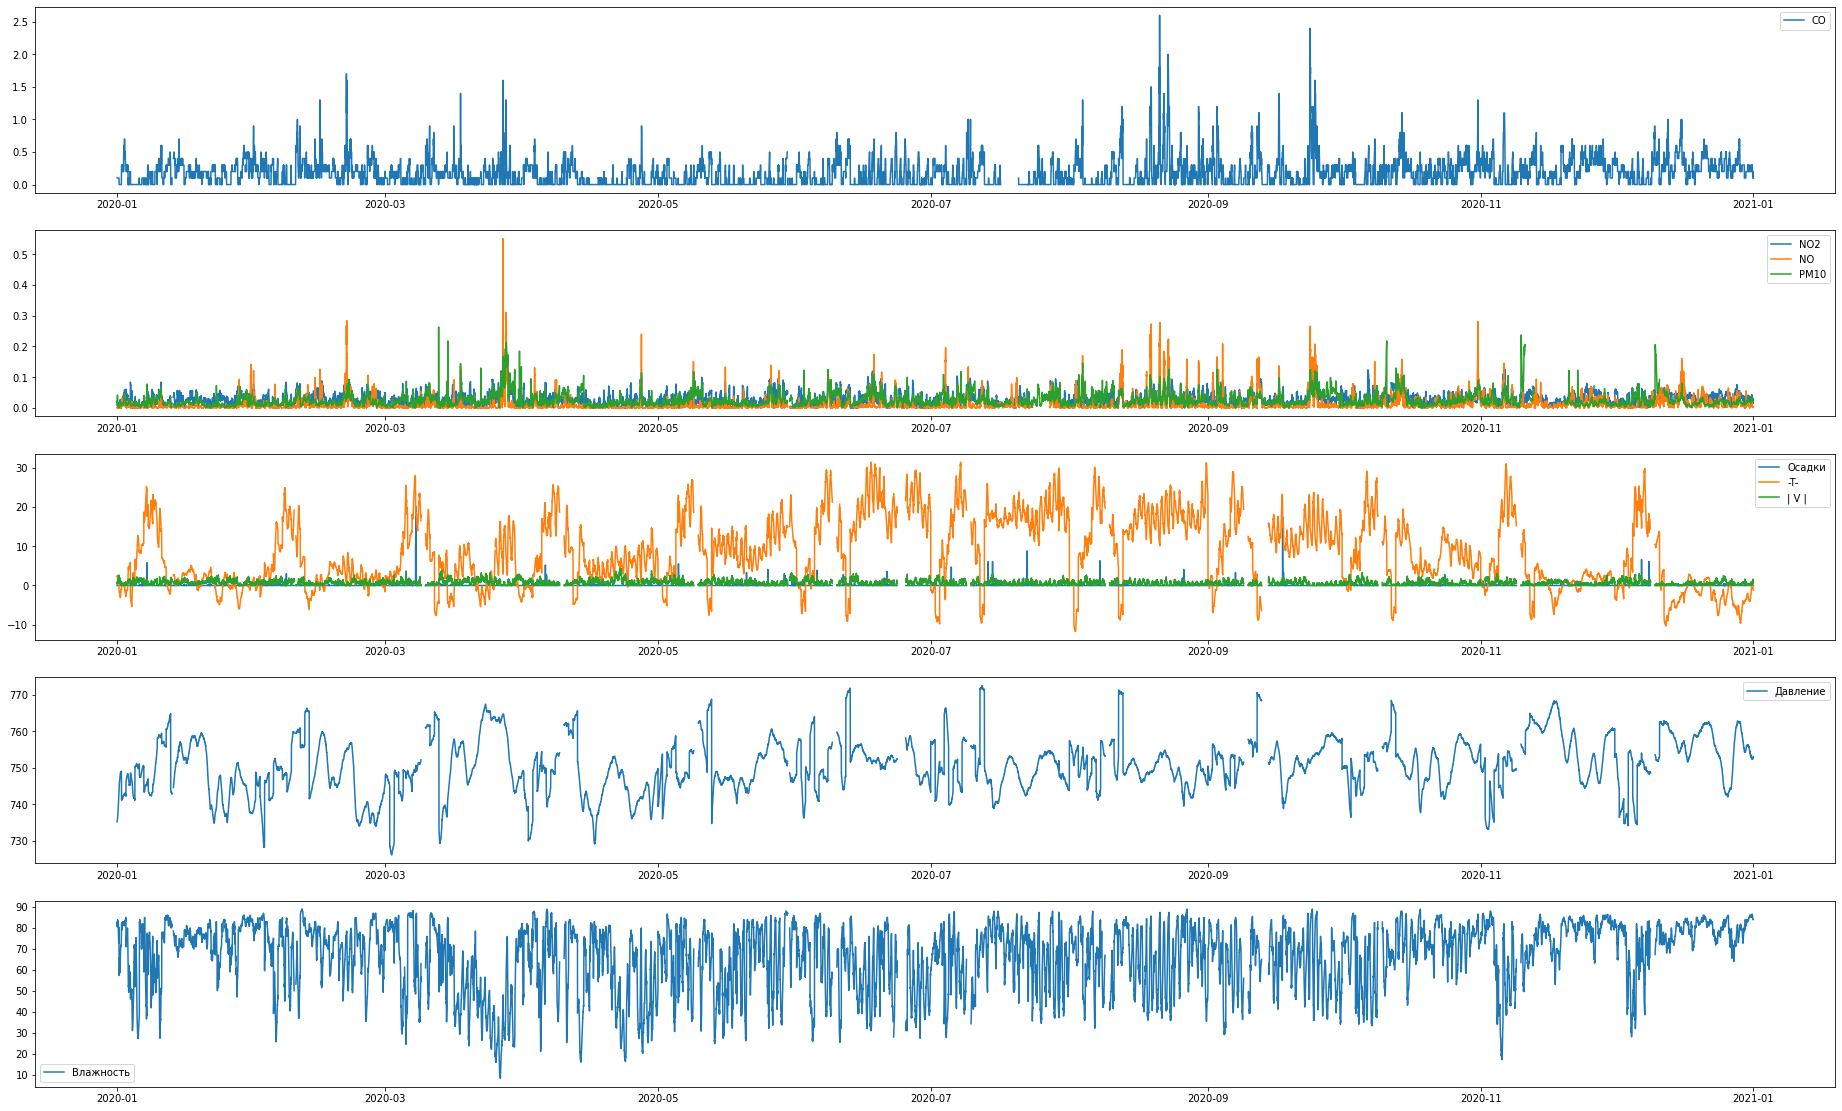

In [10]:
plot_report(datasets['Марьино'])

In [11]:
datasets.keys()

dict_keys(['Коптевский', 'Глебовская', 'Останкино', 'Академика', 'Спиридоновка', 'Шаболовка', 'Туристская', 'Бутлерова', 'Пролетарский', 'Марьино'])

### Экстракция признаков и обучение

In [12]:
def  extract_feats(data):
    _, week, weekday = list(zip(*data.reset_index()['Дата и время'].apply(pd.Timestamp.isocalendar)))
    data['weekday'] = weekday
    data['week'] = week
    
    
    data['hour'] = data.reset_index()['Дата и время'].dt.hour.values
    data['yearday'] = data.reset_index()['Дата и время'].dt.dayofyear.values
    data['month'] = data.reset_index()['Дата и время'].dt.month.values
    #data['weekday'] = data.reset_index()['Дата и время'].dt.weekday.values
    #data['week'] = data.reset_index()['Дата и время'].dt.week.values
    data['holidays'] = data.reset_index()['Дата и время'].dt.date.isin(holidays.keys()).astype(int).values
    return data

In [13]:
targets = ['CO', 'NO2', 'NO', 'PM2.5', 'PM10']
holidays = holidays.CountryHoliday('RU')
holidays.get('2020-01-01')
holidays.get('2021-01-01')

results = {}

for key in datasets:
    data = datasets[key].copy()
    cols = data.columns.to_list()
    
    data['Дата и время'] = data['Дата и время'].dt.round('1h')
    data = data.groupby(by=['Дата и время']).mean().reset_index()
    data = data.reset_index(drop=True).set_index('Дата и время')
    
    preds = {}
    reals = {}
    for target in targets:
        if target in cols:
            tmp = data[ [target] + ['-T-', '| V |', '_V_', 'Давление', 'Влажность', 'Осадки'] ]
            tmp = extract_feats(tmp.copy())
            tmp = tmp.fillna(0)
            
            X_train = tmp[:].drop([target], axis = 1)
            y_train = tmp.loc[:, target]
            
            bm = lgb.LGBMRegressor()
            bm.fit(X_train, y_train)
            
            pred_y = bm.predict(X_train)
            true_y = y_train.values
            
            print(key, target, np.mean(np.abs(pred_y / (true_y+1))))
            
            preds[target] = pred_y
            reals[target] = y_train
            
    results[key] = {'preds': preds, 'reals': reals}

Коптевский CO 0.10840659961337232
Коптевский NO2 0.026708434412944453
Коптевский NO 0.012024923631239486
Коптевский PM2.5 0.006708073046549597
Глебовская CO 0.17223775188349782
Глебовская NO2 0.02026568034999578
Глебовская NO 0.00715636606434524
Глебовская PM10 0.01941240129896584
Останкино CO 0.10843708548941296
Останкино NO2 0.02475490295357901
Останкино NO 0.015975182295205236
Останкино PM2.5 0.005489365236825048
Останкино PM10 0.01507519949357322
Академика CO 0.11171943417217363
Академика NO2 0.024715934446314074
Академика NO 0.01192016902010042
Академика PM2.5 0.005572084192373529
Спиридоновка CO 0.22648184666051288
Спиридоновка NO2 0.030940696161135803
Спиридоновка NO 0.009255170461869095
Спиридоновка PM2.5 0.009273042152246344
Спиридоновка PM10 0.019941166357298323
Шаболовка CO 0.20949034243487769
Шаболовка NO2 0.026162070398811108
Шаболовка NO 0.00905857728831648
Шаболовка PM10 0.021920340786050888
Туристская CO 0.15920654898008488
Туристская NO2 0.021608898323011452
Туристская

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

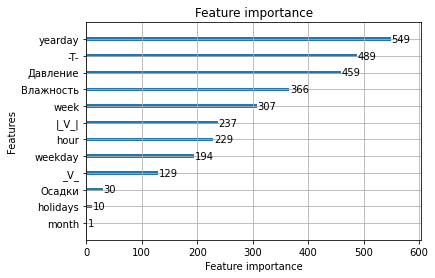

In [14]:
lgb.plot_importance(bm)

### Проверка работы модели

In [15]:
target = 'CO'
post_name = 'Пролетарский'

pred = results[post_name]['preds'][target]
real = results[post_name]['reals'][target]

In [16]:
mask_check = (y_train.index >= '2020-09-21 19:00:00') & (y_train.index < '2020-10-01 19:00:00')

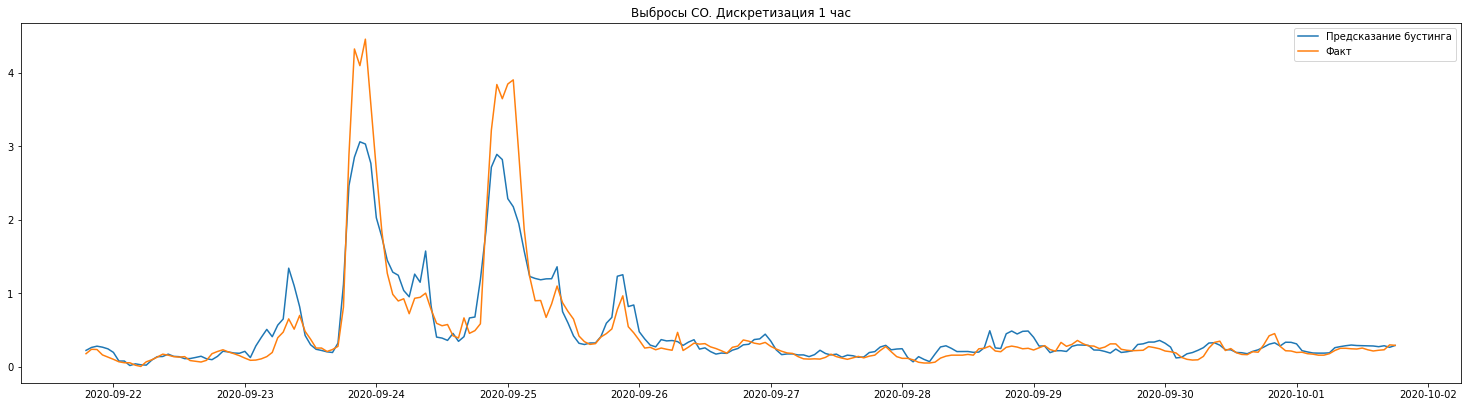

In [17]:
fig, ax = plt.subplots(1)

ax.plot(real.index[mask_check == True], np.abs(pred[mask_check == True]))
ax.plot(real.index[mask_check == True], real.values[mask_check == True])
ax.legend(['Предсказание бустинга', 'Факт'])
ax.set_title('Выбросы {}. Дискретизация 1 час'.format(target))

set_size(20,5)

### Сохраняем предсказания модели

In [18]:
maper = {
    'Академика': 'Академика Анохина',
    'Бутлерова': 'Бутлерова',
    'Глебовская': 'Глебовская',
    'Коптевский': 'Коптевский бул',
    'Марьино': 'Марьино',
    'Останкино': 'Останкино',
    'Пролетарский': 'Пролетарский проспект',
    'Спиридоновка': 'Спиридоновка',
    'Туристская': 'Туристская',
    'Шаболовка': 'Шаболовка'
}

In [19]:
for post_name in tqdm(list(results.keys())):
    elems = list(results[post_name]['reals'].keys())
    tmp = pd.DataFrame(results[post_name]['reals'][elems[0]].index).rename(columns={'Дата и время': 'datetime'})
    for elem in elems:
        tmp['pred_'+elem] = results[post_name]['preds'][elem]
    correct_name = maper[post_name]
    tmp.to_csv('./preds/2020_{}.csv'.format(correct_name), index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.85it/s]


### Пример предсказания модели на 1 января 2021 года

In [20]:
day_pred_start = datetime.datetime(2021, 1, 1, 0, 0)
day_pred_range = [day_pred_start + datetime.timedelta(hours=i) for i in range(24)]

tm = [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0]
ws = [4.9,4.9,4.9,4.9,4.8,4.7,4.5,4.5,4.6,4.6,4.6,4.7,4.9,4.8,4.8,4.7,4.7,4.7,4.8,4.9,5.1,5.3,4.9,4.9]
wd = [130 for i in range(24)] # Ю-В
pr = [750,750,750,750,750,750,750,749,749,749,749,749,749,749,749,749,748,748,748,748,748,748,748,748]
rh = [97,98,97,98,98,97,98,97,97,97,98,98,98,97,96,96,96,96,96,96,96,95,97,97]
rd = [0 for i in range(24)]

In [21]:
pred_data = pd.DataFrame()

pred_data['Дата и время'] = day_pred_range
pred_data['-T-'] = tm
pred_data['| V |'] = ws
pred_data['_V_'] = wd
pred_data['Давление'] = pr
pred_data['Влажность'] = rh
pred_data['Осадки'] = rd

In [22]:
feats = extract_feats(pred_data.copy()).set_index('Дата и время')

In [23]:
# сохраненная модель через __main__.py
model_path = '../models/predictor/p_168e8bb446624bef8b6efe6028e95503.pkl'
model = joblib.load(model_path)

In [24]:
for post_name in tqdm(list(results.keys())):
    elems = list(results[post_name]['reals'].keys())
    tmp = pd.DataFrame(feats.index).rename(columns={'Дата и время': 'datetime'})
    for elem in elems:
        tmp['pred_'+elem] = model[post_name][elem].predict(feats)
    correct_name = maper[post_name]
    tmp.to_csv('./preds/1jan2021_{}.csv'.format(correct_name), index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.42it/s]
